# Architecture

## Feature Learning

In [1278]:
# import numpy as np
# import tensorflow as tf
# import keras
# import torch
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as pltgs
# from keras.datasets import mnist
# from keras.utils import to_categorical

In [1340]:
import importlib
from src import utils
importlib.reload(utils)

<module 'src.utils' from '/Users/chadschupbach/projects/personal/mnist/src/utils.py'>

In [1129]:
x = utils.Load(method='torch').mnist(sample=9)
# x2 = utils.Load(method='torch').image(fn='data/boat.tiff')
# x3 = utils.Load(method='torch').image(fn='data/mandrill.tiff')

In [1145]:
conv = torch.nn.Conv2d(in_channels=1,
                       out_channels=6,
                       kernel_size=3,
                       stride=1,
                       padding=0)
conv2 = torch.nn.Conv2d(in_channels=1,
                       out_channels=12,
                       kernel_size=3,
                       stride=1,
                       padding=0)

In [1218]:
type(cx1)

numpy.ndarray

In [1276]:
cx1 = conv(x1).detach().numpy()
cx2 = conv2(x1).detach().numpy()

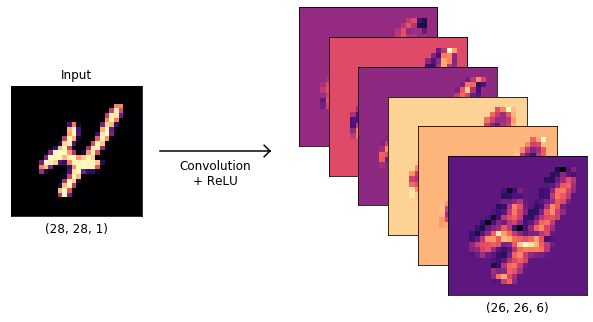

In [1277]:
utils.Plot(width=8, height=4).network(
    x_input=x1.detach().numpy(),
    x_list=[cx1]
)

(1, 10, 24, 24)

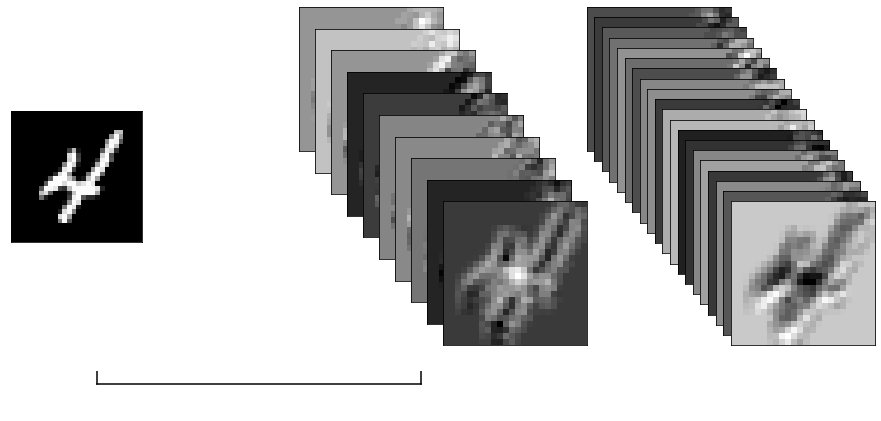

In [1131]:
cx1 = conv(x1).detach().numpy()
cx2 = conv2(x1).detach().numpy()
utils.Plot().network(x1, [cx1, cx2])
cx1.shape

### Convolution Layer

**Keras**

In [50]:
from keras.layers import Conv1D, Conv2D, Conv3D

**PyTorch**

In [88]:
from torch.nn import Conv1d, Conv2d, Conv3d

Takes input image $x_\text{in}$ and applies a kernel function $\Omega$, such that,

$$x_\text{out} = \Omega(x_\text{in})\tag{1}$$

where the output image $x_\text{out}$ is the result of convolution using kernel function $\Omega$ and the input image $x_\text{in}$. The dimensions of $x_\text{out} \in \mathbb{R}^{W_\text{out} \times H_\text{out} \times D_\text{out}}$ are dependent on the dimensions of $x_\text{in} \in \mathbb{R}^{W_\text{in} \times H_\text{in} \times D_\text{in}}$ and the hyperparameters of the kernel function $\Omega$: the number of kernels $K$, kernel size $F$, the stride $S$, and the amount of padding $P$.

$$x_\text{in} \in \mathbb{R}^{W_\text{in} \times H_\text{in} \times D_\text{in}} \quad\overset{\Omega}{\longrightarrow}\quad x_\text{out} \in \mathbb{R}^{W_\text{out} \times H_\text{out} \times D_\text{out}}$$

where

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1\tag{2}$$

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1\tag{3}$$

$$D_\text{out} = K\tag{4}$$

For example, let $x_\text{in} \in \mathbb{R}^{5 \times 5 \times 1}$ and the kernel filter $\omega \in \mathbb{R}^{3 \times 3}$. We compute the dimensions of the $x_\text{out}$ resuting from convolution of $x_\text{in}$ and $\omega$ using stride $S=1$ and no padding $P=0$ as follows:

$$W_\text{out} = \frac{W_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$H_\text{out} = \frac{H_\text{in} - F + 2P}{S} + 1 = \frac{5 - 3 + 2(0)}{1} + 1 = 3$$

$$D_\text{out} = K = 1$$

Therefore, $x_\text{out} \in \mathbb{R}^{3 \times 3 \times 1}$.

Further information about specific kernels and a more in-depth introduction to convolution can be found in the `image_processing` repository.

We load an image $x \in \mathbb{R}^{28 \times 28 \times 1}$ from the MNIST dataset below.

In [1342]:
x = utils.Load(method='torch').mnist(sample=9)

torch.Size([1, 1, 28, 28])


Note that PyTorch documentation specifies an input tensor of the form $(N, C_\text{in}, H_\text{in}, W_\text{in})$, where $N$ is the batch size, $C_\text{in}$ is the number of channels ($C_\text{in}=1$ for grayscale image and $C_\text{in}=3$ for RGB images), $H_\text{in}$ is the number of rows (in pixels), and $W_\text{in}$ is the number of columns (in pixels).

Using the PyTorch `Conv2d` function, we create two convolution objects, `conv1` and `conv2`. The first convolution object `conv1` uses 6 kernel filters ($K=6$) and no padding ($P=0$), while `conv2` uses 12 kernel filters ($K=12$) and adds zero padding ($P=1$). Both convolution objects have kernel size $F=3$ and stride $S=1$, in addition to the number of input channels being 1 (since $D_\text{in} = 1$).

In [1343]:
conv1 = Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding=0)

In [1344]:
conv2 = Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)

Convolution of the image and the random kernels is as follows:

In [1345]:
x1 = conv1(x).detach().numpy()
x2 = conv2(x).detach().numpy()

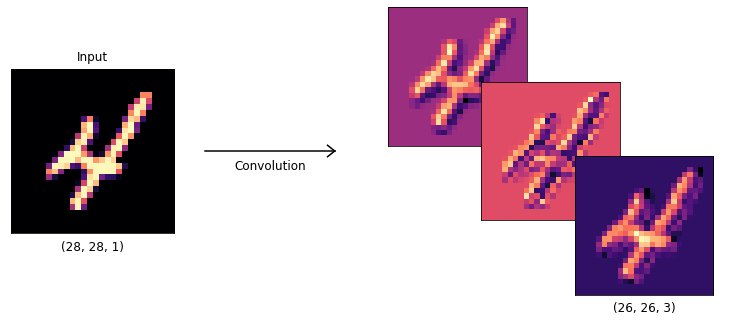

In [1346]:
utils.Plot().network(x, [x1])

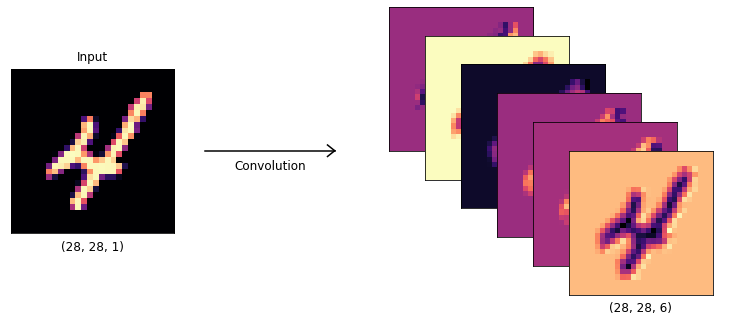

In [1347]:
utils.Plot().network(x, [x2])

### Activation Layer

We use activation functions to increase non-linearity in the network. In theory, applying an activation function to convolutional layers is similar to biological action potential thresholding in the firing of neurons.

#### Rectified Linear Unit  (ReLU)
$$f(x) = \begin{cases} 0 & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

Here we provide an example of convolution with ReLU activation using Keras. By default, Keras requires an input tensor of the form $(N, H_\text{in}, W_\text{in}, C_\text{in})$, which is known as *channels last* format. We load the same MNIST image in *channels last* format as follows:

In [1348]:
x = utils.Load(method='keras').mnist(sample=9)

(1, 28, 28, 1)


In [1349]:
pad = keras.layers.ZeroPadding2D(padding=(1,1))
conv1 = Conv2D(filters=3, kernel_size=3, strides=1, activation='relu')
conv2 = Conv2D(filters=6, kernel_size=3, strides=1, activation='relu')

In [1350]:
x1 = conv1(x)
x2 = conv2(pad(x))

We convert the tensors to numpy arrays for plotting as follows:

In [1351]:
x1 = keras.backend.eval(x1)
x2 = keras.backend.eval(x2)

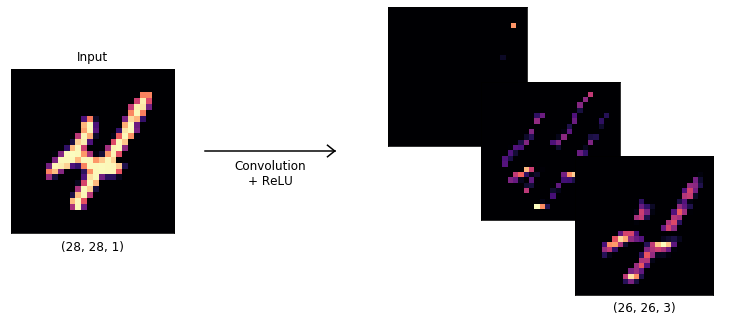

In [1352]:
utils.Plot().network(x, [x1], activation='ReLU', channels='last')

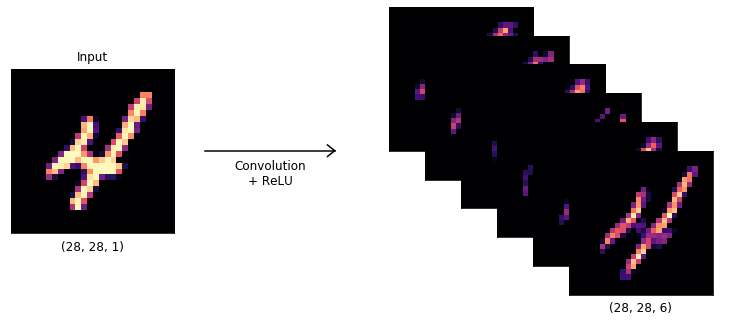

In [1353]:
utils.Plot().network(x, [x2], activation='ReLU', channels='last')

/Users/chadschupbach/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


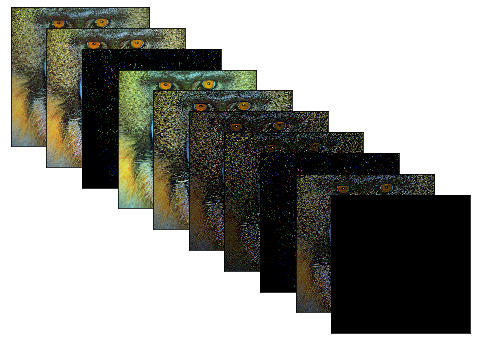

In [600]:
rgb_relu = conv(read_image('data/mandrill.tiff', as_torch=False))
_plot_conv_rgb(keras.backend.eval(rgb_relu))

#### Sigmoid
$$f(x) = \sigma(x) = \frac{1}{1 + e^{-x}}$$

In [601]:
sigmoid = keras.layers.Activation('sigmoid')
sigmoid = torch.nn.Sigmoid()

In [602]:
conv.activation = keras.layers.Activation('sigmoid')

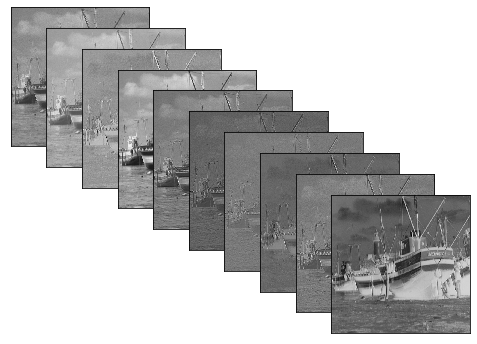

In [603]:
_plot_conv_bw(keras.backend.eval(
    conv(read_image('data/boat.tiff', as_torch=False))
))

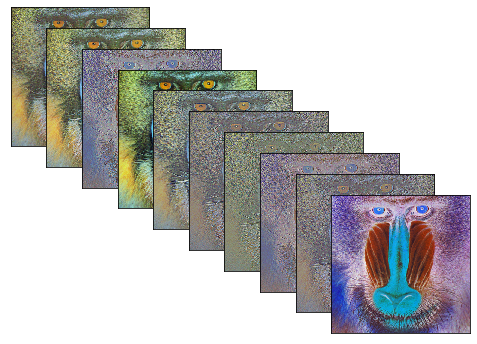

In [605]:
_plot_conv_rgb(keras.backend.eval(
    conv(read_image('data/mandrill.tiff', as_torch=False))
))

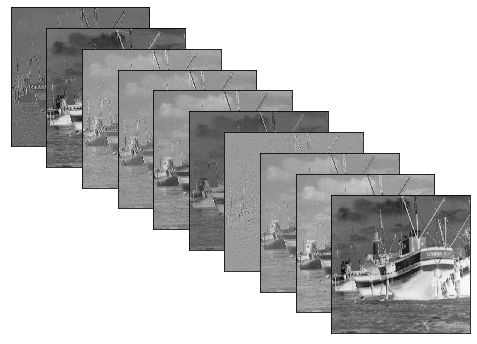

In [479]:
_plot_conv_bw(sigmoid(bw).detach().numpy())

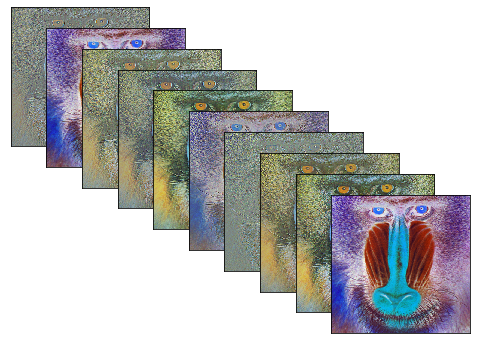

In [482]:
_plot_conv_rgb(sigmoid(rgb).detach().numpy())

#### Hyperbolic Tangent (tanh)
$$f(x) = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

In [483]:
tanh = keras.layers.Activation('tanh')
tanh = torch.nn.Tanh()

#### Softmax
$$P(y=j| \mathbf{x}) = \frac{e^{\mathbf{x}^\mathsf{T}\mathbf{w}_j}}{\sum_{k=1}^{k} e^{\mathbf{x}^\mathsf{T}\mathbf{w}_k}}$$

In [497]:
softmax = keras.layers.Activation('softmax')
softmax = torch.nn.Softmax()

#### Exponential Linear Unit (ELU)
$$f(\alpha, x) = \begin{cases} \alpha (e^x - 1) & \text{for } x \leq 0 \\
x & \text{for } x > 0 \end{cases}$$

In [83]:
elu = keras.layers.Activation('elu')
elu = torch.nn.ELU()

#### Softplus
$$f(x) = \ln(1 + e^x)$$

In [84]:
softplus = keras.layers.Activation('softplus')
softplus = torch.nn.Softplus()

#### Softsign
$$f(x) = \frac{x}{1 + |x|}$$

In [85]:
softsign = keras.layers.Activation('softsign')
softsign = torch.nn.Softsign()

#### Others

- Leaky ReLU

- PReLU

- RReLU

- SELU

- GELU

### Pooling Layer

#### Max Pooling

In [86]:
from keras.layers import MaxPooling1D, MaxPooling2D, MaxPooling3D
from torch.nn import MaxPool1d, MaxPool2d, MaxPool3d

#### Average Pooling

In [87]:
from keras.layers import AveragePooling1D, AveragePooling2D, AveragePooling3D
from torch.nn import AvgPool1d, AvgPool2d, AvgPool3d

### Loss Layer

### Regularization

### Dropout